# All Models Fusion

## Set up

###  Install required packages.

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = "ignore"
print(torch.__version__)
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

2.6.0+cu124
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-7uwjo79t
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-7uwjo79t
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 4410298df8de8ca9f13ba4ee12e6a30ec82c42d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Unzip Data and Utils

In [ ]:
!unzip "utils.zip" -d '.'

Archive:  utils.zip
   creating: ./utils/
   creating: ./utils/__pycache__/
  inflating: ./__MACOSX/utils/.___pycache__  
  inflating: ./utils/threshold.py    
  inflating: ./utils/comparing.py    
  inflating: ./utils/__pycache__/comparing.cpython-312.pyc  
  inflating: ./__MACOSX/utils/__pycache__/._comparing.cpython-312.pyc  
  inflating: ./utils/__pycache__/threshold.cpython-312.pyc  
  inflating: ./__MACOSX/utils/__pycache__/._threshold.cpython-312.pyc  


In [ ]:
!unzip "data.zip" -d '.'

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
  inflating: ./__MACOSX/data/external/rphunter/Dataset/Incidents-Source-Code/2024-5-2-NovaMind/._@openzeppelin  
  inflating: ./data/external/rphunter/Dataset/Incidents-Source-Code/2021-11-25-Sloth Inu/0x85bcaee8befa419becb90e8b405d131ee9e31877.sol  
  inflating: ./__MACOSX/data/external/rphunter/Dataset/Incidents-Source-Code/2021-11-25-Sloth Inu/._0x85bcaee8befa419becb90e8b405d131ee9e31877.sol  
  inflating: ./data/external/rphunter/Dataset/Incidents-Source-Code/2021-8-26-Snakedefi/0xf882413338a88F3d41f0df4c31d8CA5d33e3e3d1.sol  
  inflating: ./__MACOSX/data/external/rphunter/Dataset/Incidents-Source-Code/2021-8-26-Snakedefi/._0xf882413338a88F3d41f0df4c31d8CA5d33e3e3d1.sol  
  inflating: ./data/external/rphunter/Dataset/Incidents-Source-Code/2022-9-22-SiriusToken/0x9bc699780A326C059C660C6ee2EF1D8583D01aEa.sol  
  inflating: ./__MACOSX/data/external/rphunter/Dataset/Incidents-Source-Code/2022-9-22-SiriusToken/._0x9bc699780A326C05

### Import and Var

In [96]:
import warnings
warnings.filterwarnings("ignore")

In [97]:
import os
import pandas as pd
from pathlib import Path
import json
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch_geometric.utils import from_networkx

from utils.comparing import report_for_multiple_model_as_same_set, evaluate_multilabel_classification
from utils.threshold import tune_thresholds

PATH = './data/labeled'

## Load Data

In [98]:
def load_feature(file):
    df = pd.read_csv(os.path.join(PATH, file), index_col=0)
    df.index = df.index.str.lower()
    return df

In [99]:
y = load_feature('groundtruth.csv')
label_cols = [col for col in y.columns]
y.index = y.index.str.lower()
addresses = y.index.tolist()

### Split Train

In [100]:
train_idx, test_idx = train_test_split(addresses, test_size=0.3, random_state=42)
y_train = y.loc[train_idx]
y_test = y.loc[test_idx]

#### Label distibution

##### Train

In [101]:
label_counts = y_train[label_cols].sum()
label_counts

,0
Mint,12
Leak,5
Limit,18


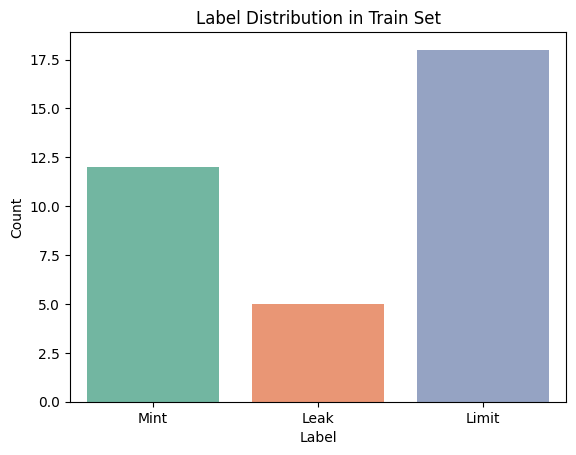

In [102]:
sns.barplot(x=label_counts.index, y=label_counts.values, palette="Set2")
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution in Train Set')
plt.show()

###### Plot Count of Label Combinations

In [103]:
combine_df = pd.DataFrame({})
# Convert one-hot columns to label strings
def get_labels(row):
    return ','.join([
        label for label in label_cols
        if row[label] == 1
    ])

combine_df['label_combo'] = y_train.apply(get_labels, axis=1)
combine_df['label_combo'] = combine_df['label_combo'].replace('', 'None')  # Replace empty with 'None'
# Count combinations
combo_counts = combine_df['label_combo'].value_counts()
combo_counts

,count
label_combo,
None,20
Limit,12
Mint,6
"Mint,Limit",5
Leak,3
"Mint,Leak",1
"Leak,Limit",1


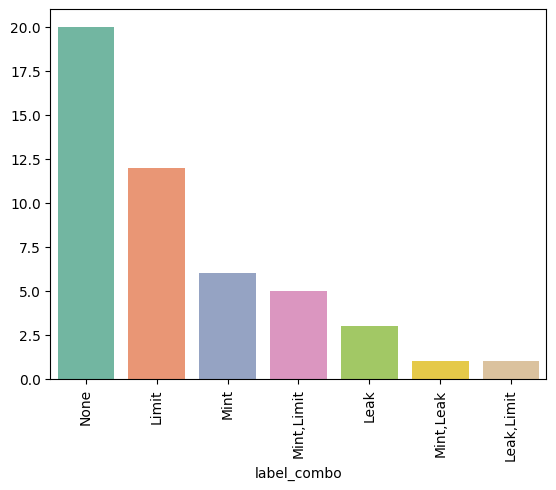

In [104]:
sns.barplot(x=combo_counts.index, y=combo_counts.values, palette="Set2")
plt.xticks(rotation=90)
plt.show()

##### Test

In [105]:
label_counts = y_test[label_cols].sum()
label_counts

,0
Mint,8
Leak,4
Limit,12


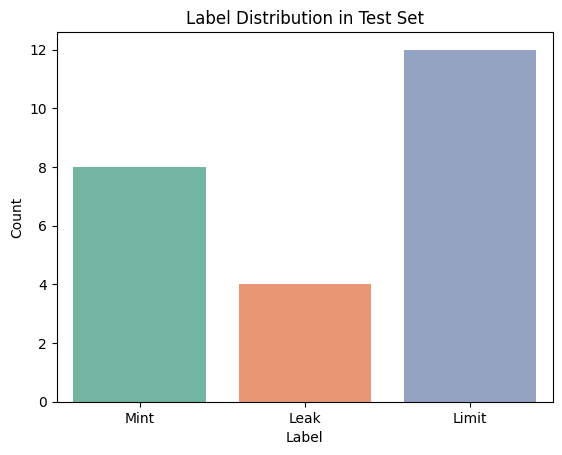

In [106]:
sns.barplot(x=label_counts.index, y=label_counts.values, palette="Set2")
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution in Test Set')
plt.show()

###### Plot Count of Label Combinations

In [107]:
combine_df = pd.DataFrame({})
# Convert one-hot columns to label strings
def get_labels(row):
    return ','.join([
        label for label in label_cols
        if row[label] == 1
    ])

combine_df['label_combo'] = y_test.apply(get_labels, axis=1)
combine_df['label_combo'] = combine_df['label_combo'].replace('', 'None')  # Replace empty with 'None'
# Count combinations
combo_counts = combine_df['label_combo'].value_counts()
combo_counts

,count
label_combo,
None,7
"Mint,Limit",5
Limit,3
"Leak,Limit",3
Mint,2
"Mint,Leak,Limit",1


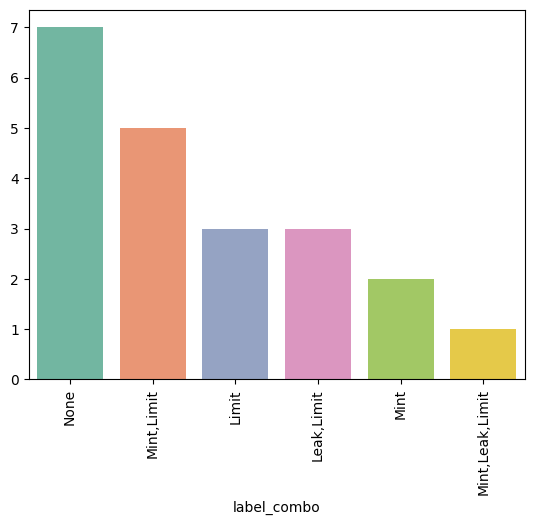

In [108]:
sns.barplot(x=combo_counts.index, y=combo_counts.values, palette="Set2")
plt.xticks(rotation=90)
plt.show()

## Model

### For txn_static_feature_model

In [109]:
df = load_feature('transaction_feature.csv')
df.index = df.index.str.lower()

# Filter train_idx and test_idx to include only addresses present in df.index
train_idx_filtered = [idx for idx in train_idx if idx in df.index]
test_idx_filtered = [idx for idx in test_idx if idx in df.index]

X_train = df.loc[train_idx_filtered]
X_test = df.loc[test_idx_filtered]
y_train_filtered = y_train.loc[train_idx_filtered]
y_test_filtered = y_test.loc[test_idx_filtered]

#### Label distibution

##### Train

In [110]:
label_counts = y_train_filtered[label_cols].sum()
label_counts

,0
Mint,12
Leak,5
Limit,18


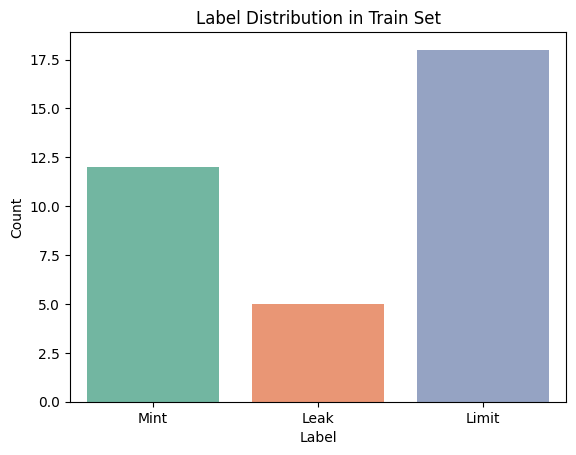

In [111]:
sns.barplot(x=label_counts.index, y=label_counts.values, palette="Set2")
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution in Train Set')
plt.show()

###### Plot Count of Label Combinations

In [112]:
combine_df = pd.DataFrame({})
# Convert one-hot columns to label strings
def get_labels(row):
    return ','.join([
        label for label in label_cols
        if row[label] == 1
    ])

combine_df['label_combo'] = y_train_filtered.apply(get_labels, axis=1)
combine_df['label_combo'] = combine_df['label_combo'].replace('', 'None')  # Replace empty with 'None'
# Count combinations
combo_counts = combine_df['label_combo'].value_counts()
combo_counts

,count
label_combo,
None,20
Limit,12
Mint,6
"Mint,Limit",5
Leak,3
"Mint,Leak",1
"Leak,Limit",1


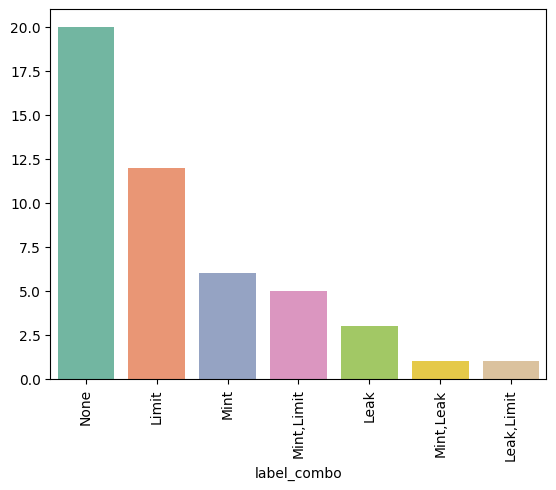

In [113]:
sns.barplot(x=combo_counts.index, y=combo_counts.values, palette="Set2")
plt.xticks(rotation=90)
plt.show()

##### Test

In [114]:
label_counts = y_test_filtered[label_cols].sum()
label_counts

,0
Mint,8
Leak,4
Limit,12


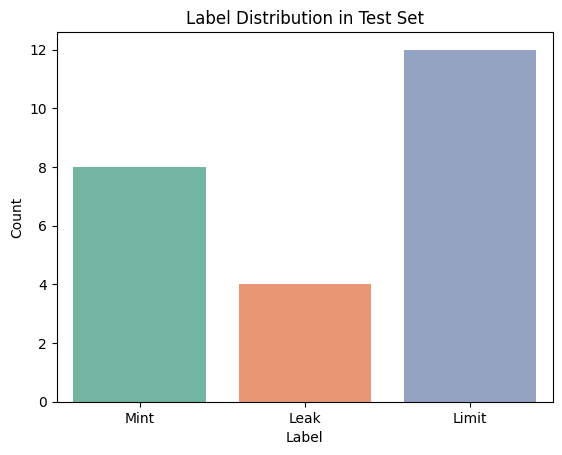

In [115]:
sns.barplot(x=label_counts.index, y=label_counts.values, palette="Set2")
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution in Test Set')
plt.show()

###### Plot Count of Label Combinations

In [116]:
combine_df = pd.DataFrame({})
# Convert one-hot columns to label strings
def get_labels(row):
    return ','.join([
        label for label in label_cols
        if row[label] == 1
    ])

combine_df['label_combo'] = y_test.apply(get_labels, axis=1)
combine_df['label_combo'] = combine_df['label_combo'].replace('', 'None')  # Replace empty with 'None'
# Count combinations
combo_counts = combine_df['label_combo'].value_counts()
combo_counts

,count
label_combo,
None,7
"Mint,Limit",5
Limit,3
"Leak,Limit",3
Mint,2
"Mint,Leak,Limit",1


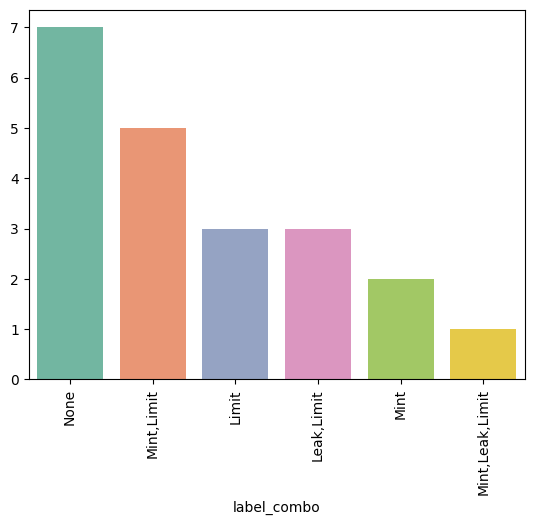

In [117]:
sns.barplot(x=combo_counts.index, y=combo_counts.values, palette="Set2")
plt.xticks(rotation=90)
plt.show()

#### Result

In [118]:
report_df, _ = report_for_multiple_model_as_same_set(X_train, X_test, y_train_filtered, y_test_filtered)
report_df.sort_values(by='macro avg f1', ascending=False)

[LightGBM] [Info] Number of positive: 12, number of negative: 36
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 225
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.250000 -> initscore=-1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

,micro avg f1,macro avg f1,Mint f1,Leak f1,Limit f1
MultiOutput(RandomForest),0.521739,0.448815,0.222222,0.428571,0.695652
OneVsRest(RandomForest),0.521739,0.448815,0.222222,0.428571,0.695652
OneVsRest(LogisticRegression),0.509804,0.433939,0.181818,0.400000,0.720000
MultiOutput(LogisticRegression),0.509804,0.433939,0.181818,0.400000,0.720000
OneVsRest(GaussianNB),0.491803,0.357771,0.000000,0.363636,0.709677
MultiOutput(GaussianNB),0.491803,0.357771,0.000000,0.363636,0.709677
MultiOutput(MLP),0.238095,0.183333,0.250000,0.000000,0.300000
OneVsRest(MLP),0.238095,0.183333,0.250000,0.000000,0.300000
MultiOutput(SGD),0.206897,0.157407,0.222222,0.000000,0.250000
OneVsRest(SGD),0.206897,0.157407,0.222222,0.000000,0.250000


### For bytecode_static_feature_model

In [119]:
df = load_feature('bytecode_feature.csv')
df.index = df.index.str.lower()

# Filter train_idx and test_idx to include only addresses present in df.index
train_idx_filtered = [idx for idx in train_idx if idx in df.index]
test_idx_filtered = [idx for idx in test_idx if idx in df.index]

X_train = df.loc[train_idx_filtered]
X_test = df.loc[test_idx_filtered]
y_train_filtered = y_train.loc[train_idx_filtered]
y_test_filtered = y_test.loc[test_idx_filtered]

#### Label distibution

##### Train

In [120]:
label_counts = y_train_filtered[label_cols].sum()
label_counts

,0
Mint,12
Leak,5
Limit,18


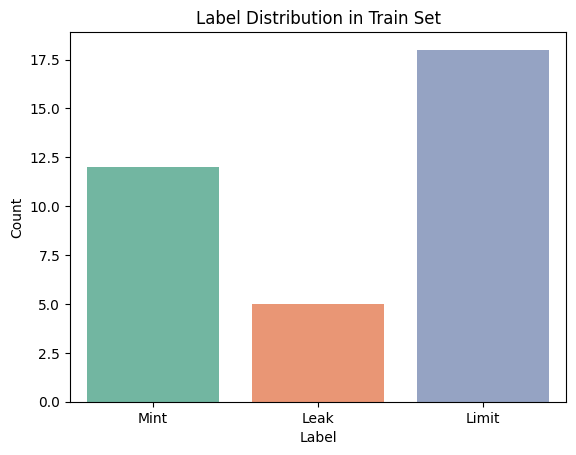

In [121]:
sns.barplot(x=label_counts.index, y=label_counts.values, palette="Set2")
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution in Train Set')
plt.show()

###### Plot Count of Label Combinations

In [122]:
combine_df = pd.DataFrame({})
# Convert one-hot columns to label strings
def get_labels(row):
    return ','.join([
        label for label in label_cols
        if row[label] == 1
    ])

combine_df['label_combo'] = y_train_filtered.apply(get_labels, axis=1)
combine_df['label_combo'] = combine_df['label_combo'].replace('', 'None')  # Replace empty with 'None'
# Count combinations
combo_counts = combine_df['label_combo'].value_counts()
combo_counts

,count
label_combo,
None,20
Limit,12
Mint,6
"Mint,Limit",5
Leak,3
"Mint,Leak",1
"Leak,Limit",1


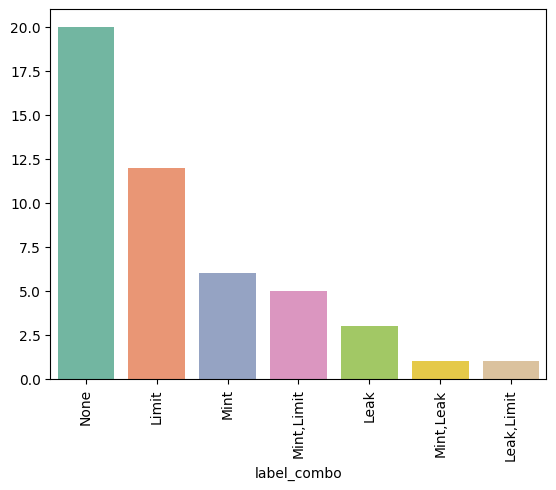

In [123]:
sns.barplot(x=combo_counts.index, y=combo_counts.values, palette="Set2")
plt.xticks(rotation=90)
plt.show()

##### Test

In [124]:
label_counts = y_test_filtered[label_cols].sum()
label_counts

,0
Mint,8
Leak,4
Limit,12


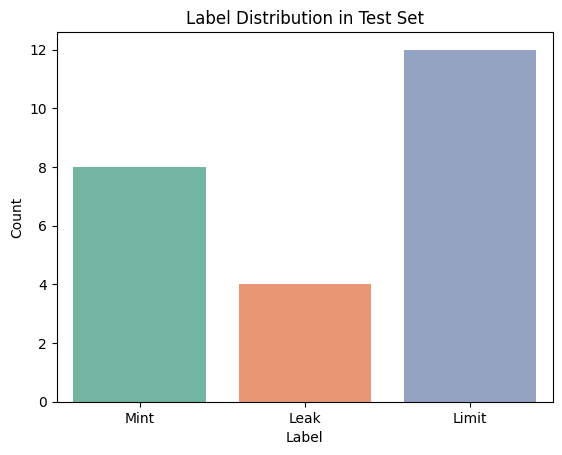

In [125]:
sns.barplot(x=label_counts.index, y=label_counts.values, palette="Set2")
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution in Test Set')
plt.show()

###### Plot Count of Label Combinations

In [126]:
combine_df = pd.DataFrame({})
# Convert one-hot columns to label strings
def get_labels(row):
    return ','.join([
        label for label in label_cols
        if row[label] == 1
    ])

combine_df['label_combo'] = y_test.apply(get_labels, axis=1)
combine_df['label_combo'] = combine_df['label_combo'].replace('', 'None')  # Replace empty with 'None'
# Count combinations
combo_counts = combine_df['label_combo'].value_counts()
combo_counts

,count
label_combo,
None,7
"Mint,Limit",5
Limit,3
"Leak,Limit",3
Mint,2
"Mint,Leak,Limit",1


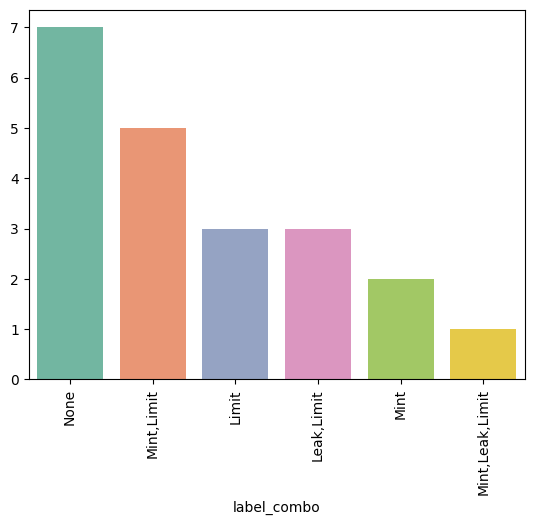

In [127]:
sns.barplot(x=combo_counts.index, y=combo_counts.values, palette="Set2")
plt.xticks(rotation=90)
plt.show()

#### Result

In [128]:
report_df, _ = report_for_multiple_model_as_same_set(X_train, X_test, y_train_filtered, y_test_filtered)
report_df.sort_values(by='macro avg f1', ascending=False)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 12, number of negative: 36
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9678
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 915
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.250000 -> initscore=-1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

,micro avg f1,macro avg f1,Mint f1,Leak f1,Limit f1
MultiOutput(RandomForest),0.564103,0.509402,0.461538,0.4,0.666667
OneVsRest(RandomForest),0.564103,0.509402,0.461538,0.4,0.666667
OneVsRest(AdaBoost),0.486486,0.444444,0.333333,0.4,0.600000
MultiOutput(AdaBoost),0.486486,0.444444,0.333333,0.4,0.600000
OneVsRest(SGD),0.521739,0.379085,0.470588,0.0,0.666667
MultiOutput(SGD),0.521739,0.379085,0.470588,0.0,0.666667
MultiOutput(ExtraTrees),0.512821,0.365079,0.428571,0.0,0.666667
OneVsRest(ExtraTrees),0.512821,0.365079,0.428571,0.0,0.666667
MultiOutput(DecisionTree),0.523810,0.342564,0.307692,0.0,0.720000
OneVsRest(DecisionTree),0.523810,0.342564,0.307692,0.0,0.720000


### For source_code_static_feature_model

In [129]:
df = load_feature('tf_idf.csv')
df.index = df.index.str.lower()

# Filter train_idx and test_idx to include only addresses present in df.index
train_idx_filtered = [idx for idx in train_idx if idx in df.index]
test_idx_filtered = [idx for idx in test_idx if idx in df.index]

X_train = df.loc[train_idx_filtered]
X_test = df.loc[test_idx_filtered]
y_train_filtered = y_train.loc[train_idx_filtered]
y_test_filtered = y_test.loc[test_idx_filtered]

#### Label distibution

##### Train

In [130]:
label_counts = y_train_filtered[label_cols].sum()
label_counts

,0
Mint,12
Leak,5
Limit,18


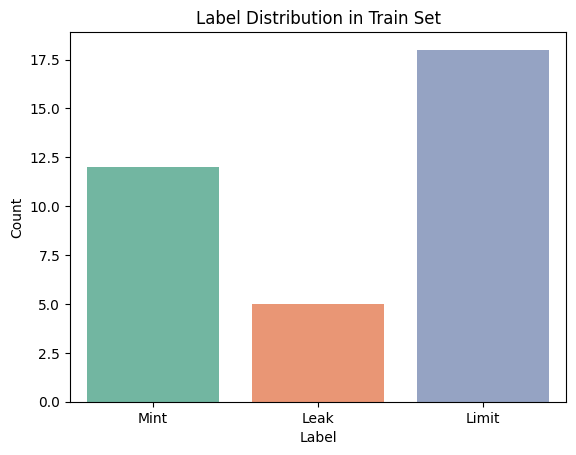

In [131]:
sns.barplot(x=label_counts.index, y=label_counts.values, palette="Set2")
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution in Train Set')
plt.show()

###### Plot Count of Label Combinations

In [132]:
combine_df = pd.DataFrame({})
# Convert one-hot columns to label strings
def get_labels(row):
    return ','.join([
        label for label in label_cols
        if row[label] == 1
    ])

combine_df['label_combo'] = y_train_filtered.apply(get_labels, axis=1)
combine_df['label_combo'] = combine_df['label_combo'].replace('', 'None')  # Replace empty with 'None'
# Count combinations
combo_counts = combine_df['label_combo'].value_counts()
combo_counts

,count
label_combo,
None,20
Limit,12
Mint,6
"Mint,Limit",5
Leak,3
"Mint,Leak",1
"Leak,Limit",1


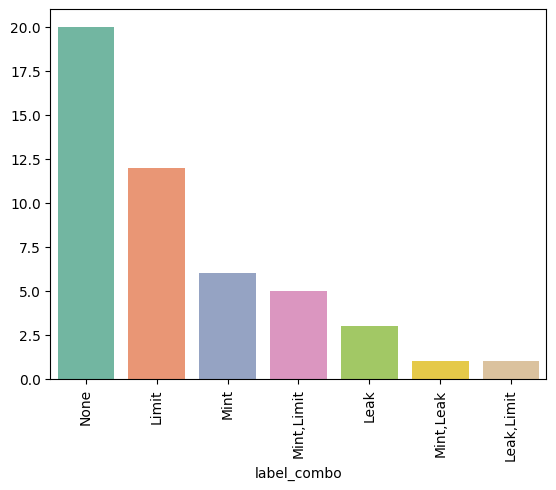

In [133]:
sns.barplot(x=combo_counts.index, y=combo_counts.values, palette="Set2")
plt.xticks(rotation=90)
plt.show()

##### Test

In [134]:
label_counts = y_test_filtered[label_cols].sum()
label_counts

,0
Mint,7
Leak,4
Limit,11


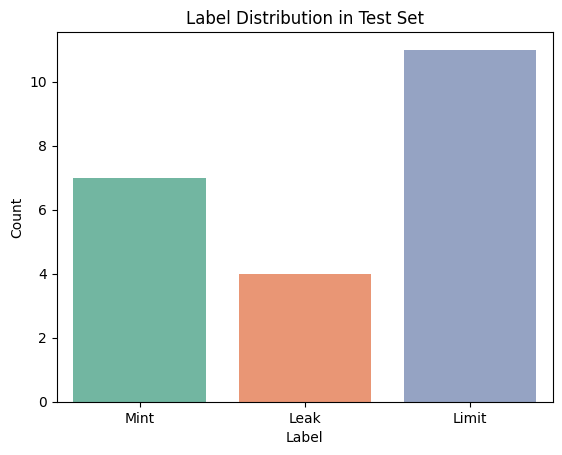

In [135]:
sns.barplot(x=label_counts.index, y=label_counts.values, palette="Set2")
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution in Test Set')
plt.show()

###### Plot Count of Label Combinations

In [136]:
combine_df = pd.DataFrame({})
# Convert one-hot columns to label strings
def get_labels(row):
    return ','.join([
        label for label in label_cols
        if row[label] == 1
    ])

combine_df['label_combo'] = y_test.apply(get_labels, axis=1)
combine_df['label_combo'] = combine_df['label_combo'].replace('', 'None')  # Replace empty with 'None'
# Count combinations
combo_counts = combine_df['label_combo'].value_counts()
combo_counts

,count
label_combo,
None,7
"Mint,Limit",5
Limit,3
"Leak,Limit",3
Mint,2
"Mint,Leak,Limit",1


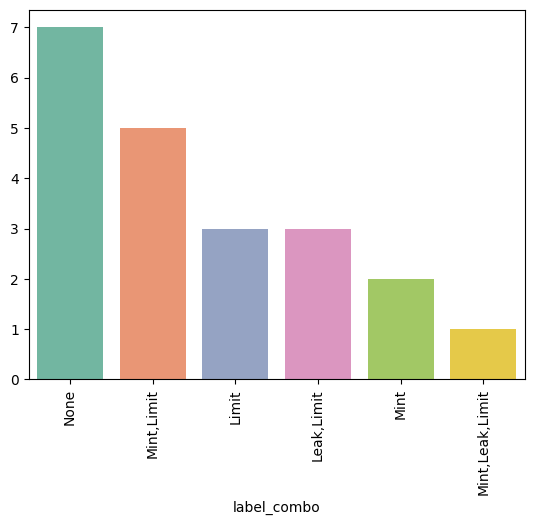

In [137]:
sns.barplot(x=combo_counts.index, y=combo_counts.values, palette="Set2")
plt.xticks(rotation=90)
plt.show()

#### Result

In [138]:
report_df, _ = report_for_multiple_model_as_same_set(X_train, X_test, y_train_filtered, y_test_filtered)
report_df.sort_values(by='macro avg f1', ascending=False)

[LightGBM] [Info] Number of positive: 12, number of negative: 36
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4158
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 355
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.250000 -> initscore=-1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


,micro avg f1,macro avg f1,Mint f1,Leak f1,Limit f1
MultiOutput(LogisticRegression),0.604651,0.554386,0.631579,0.400000,0.631579
OneVsRest(LogisticRegression),0.604651,0.554386,0.631579,0.400000,0.631579
MultiOutput(SGD),0.484848,0.440523,0.400000,0.333333,0.588235
OneVsRest(SGD),0.484848,0.440523,0.400000,0.333333,0.588235
OneVsRest(XGBoost),0.437500,0.423529,0.400000,0.400000,0.470588
MultiOutput(XGBoost),0.437500,0.423529,0.400000,0.400000,0.470588
MultiOutput(DecisionTree),0.461538,0.422365,0.461538,0.250000,0.555556
OneVsRest(DecisionTree),0.461538,0.422365,0.461538,0.250000,0.555556
MultiOutput(MLP),0.516129,0.370370,0.444444,0.000000,0.666667
OneVsRest(MLP),0.516129,0.370370,0.444444,0.000000,0.666667


### Time Series

In [139]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Masking
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [140]:
seq_len = 500
feature_dim = 5

X_train, X_test, y_train_filtered, y_test_filtered  = [], [], [], []

for path in tqdm(list(Path(os.path.join(PATH, 'txn')).glob('*.json'))):
    addr = path.stem
    data = json.load(open(path, 'r'))
    txns = sorted(data.get("transaction", []), key=lambda x: int(x.get("timeStamp", 0)))
    seq = [[
        int(tx.get("gas", 0)),
        int(tx.get("gasPrice", 0)),
        int(tx.get("value", 0)),
        int(tx.get("isError", 0)),
        int(tx.get("txreceipt_status", 0))
    ] for tx in txns]

    if len(seq) < seq_len:
        seq += [[0]*feature_dim] * (seq_len - len(seq))
    else:
        seq = seq[:seq_len]

    seq = StandardScaler().fit_transform(seq)

    if addr in train_idx:
        X_train.append(seq)
        y_train_filtered.append(y.loc[addr].tolist())
    elif addr in test_idx:
        X_test.append(seq)
        y_test_filtered.append(y.loc[addr].tolist())

100%|██████████| 69/69 [00:00<00:00, 73.04it/s]


In [141]:
len(X_train), len(y_train_filtered), len(X_test), len(y_test_filtered)

(48, 48, 21, 21)

In [142]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train_filtered = np.array(y_train_filtered)
y_test_filtered = np.array(y_test_filtered)

#### Label distibution

##### Train

In [143]:
y_dis = pd.DataFrame(y_train_filtered, columns=label_cols)
label_counts = pd.DataFrame(y_dis, columns=label_cols).sum()
label_counts

,0
Mint,12
Leak,5
Limit,18


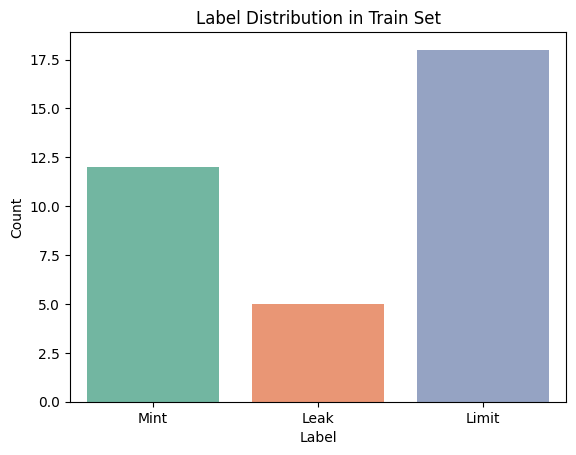

In [144]:
sns.barplot(x=label_counts.index, y=label_counts.values, palette="Set2")
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution in Train Set')
plt.show()

###### Plot Count of Label Combinations

In [145]:
combine_df = pd.DataFrame({})
# Convert one-hot columns to label strings
def get_labels(row):
    return ','.join([
        label for label in label_cols
        if row[label] == 1
    ])

combine_df['label_combo'] = y_dis.apply(get_labels, axis=1)
combine_df['label_combo'] = combine_df['label_combo'].replace('', 'None')  # Replace empty with 'None'
# Count combinations
combo_counts = combine_df['label_combo'].value_counts()
combo_counts

,count
label_combo,
None,20
Limit,12
Mint,6
"Mint,Limit",5
Leak,3
"Mint,Leak",1
"Leak,Limit",1


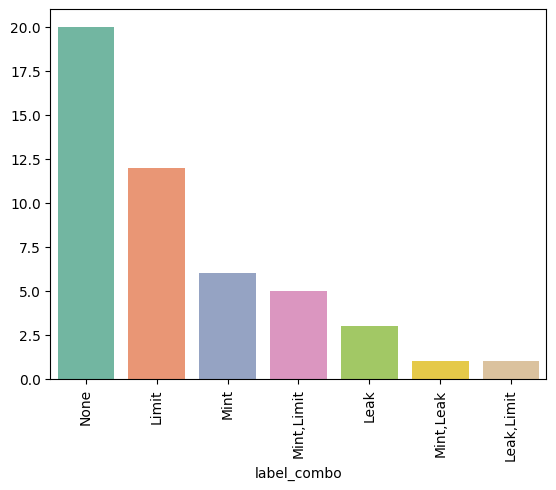

In [146]:
sns.barplot(x=combo_counts.index, y=combo_counts.values, palette="Set2")
plt.xticks(rotation=90)
plt.show()

##### Test

In [147]:
y_dis = pd.DataFrame(y_test_filtered, columns=label_cols)
label_counts = y_dis[label_cols].sum()
label_counts

,0
Mint,8
Leak,4
Limit,12


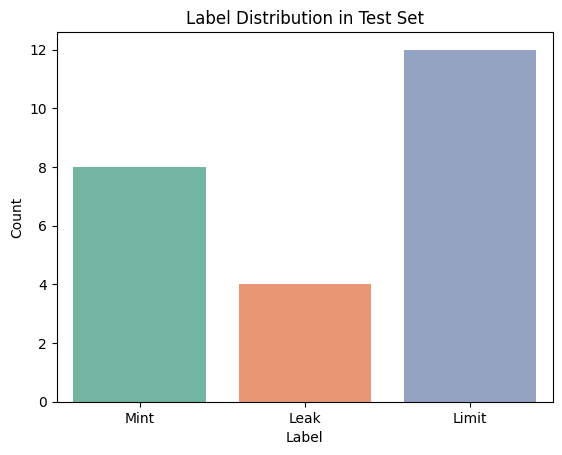

In [148]:
sns.barplot(x=label_counts.index, y=label_counts.values, palette="Set2")
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution in Test Set')
plt.show()

###### Plot Count of Label Combinations

In [149]:
combine_df = pd.DataFrame({})
# Convert one-hot columns to label strings
def get_labels(row):
    return ','.join([
        label for label in label_cols
        if row[label] == 1
    ])

combine_df['label_combo'] = y_dis.apply(get_labels, axis=1)
combine_df['label_combo'] = combine_df['label_combo'].replace('', 'None')  # Replace empty with 'None'
# Count combinations
combo_counts = combine_df['label_combo'].value_counts()
combo_counts

,count
label_combo,
None,7
"Mint,Limit",5
Limit,3
"Leak,Limit",3
Mint,2
"Mint,Leak,Limit",1


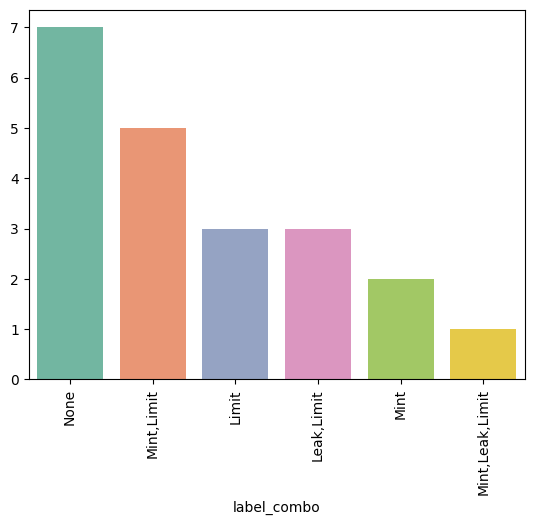

In [150]:
sns.barplot(x=combo_counts.index, y=combo_counts.values, palette="Set2")
plt.xticks(rotation=90)
plt.show()

#### Model & train

In [151]:
# === Model ===
model = Sequential([
    Masking(mask_value=0.0, input_shape=(seq_len, feature_dim)),
    GRU(64),
    Dense(len(label_cols), activation="sigmoid")
])

In [152]:
model.compile(loss=BinaryCrossentropy(), optimizer=Adam(1e-3), metrics=['accuracy'])
model.fit(X_train, y_train_filtered, epochs=30, verbose=1)

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 260ms/step - accuracy: 0.5486 - loss: 0.6967
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 419ms/step - accuracy: 0.5590 - loss: 0.6902
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 379ms/step - accuracy: 0.5382 - loss: 0.6861
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 420ms/step - accuracy: 0.5104 - loss: 0.6773
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 437ms/step - accuracy: 0.4861 - loss: 0.6742
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step - accuracy: 0.4028 - loss: 0.6660
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step - accuracy: 0.4653 - loss: 0.6594
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step - accuracy: 0.4896 - loss: 0.6535
Epoch 9/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step - accuracy: 0.4896 - loss: 0.6473
Epoch 10/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step - accuracy: 0.4896 - loss: 0.6352
Epoch 11/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - accuracy: 0.4549 - loss: 0.6298
Epoch 12/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step - accuracy: 0.4722 - lo

In [153]:
# === Predict ===
prob = model.predict(X_test)
thresholds, _ = tune_thresholds(y_test_filtered, prob)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
Label 0: Best threshold = 0.00, Best f1 = 0.5517
Label 1: Best threshold = 0.22, Best f1 = 0.4286
Label 2: Best threshold = 0.29, Best f1 = 0.8148


#### Result

In [154]:
evaluate_multilabel_classification(y_test, prob, label_cols, thresholds)

({'micro_precision': 0.41304347826086957,
  'micro_recall': 0.7916666666666666,
  'micro_f1': 0.5428571428571428,
  'macro_precision': 0.4047619047619048,
  'macro_recall': 0.8055555555555555,
  'macro_f1': 0.5242960530316852,
  'weighted_precision': 0.4436507936507937,
  'weighted_recall': 0.7916666666666666,
  'weighted_f1': 0.5516329137018792,
  'subset_accuracy': 0.14285714285714285},
               precision    recall  f1-score  support
 Mint           0.380952  1.000000  0.551724      8.0
 Leak           0.300000  0.750000  0.428571      4.0
 Limit          0.533333  0.666667  0.592593     12.0
 micro avg      0.413043  0.791667  0.542857     24.0
 macro avg      0.404762  0.805556  0.524296     24.0
 weighted avg   0.443651  0.791667  0.551633     24.0
 samples avg    0.444444  0.547619  0.449206     24.0)

### Graph

In [155]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

class GCN(nn.Module):
    def __init__(self, in_channels, hidden, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden)
        # self.conv2 = GCNConv(hidden*3, hidden*2)
        # self.conv3 = GCNConv(hidden*2, hidden)
        self.conv2 = GCNConv(hidden, hidden)
        self.lin = nn.Linear(hidden, out_channels)
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

#### Transaction

In [156]:
graph_feature = load_feature('txn_graph_features.csv')
graph_feature.index = graph_feature.index.str.lower()
graphs = pickle.load(open(os.path.join(PATH, 'txn.pkl'), 'rb'))

In [157]:
train_dataset, test_dataset = [], []
y_train_filtered, y_test_filtered = [], []
for i, (address, graph_data) in enumerate(graphs.items()):
    feature = graph_feature.loc[address]
    data = from_networkx(graph_data)

    data.x = torch.tensor(feature, dtype=torch.float32).repeat(data.num_nodes, 1) # Repeat features for each node
    data.y = torch.tensor(y.loc[address][label_cols].values, dtype=torch.float32).unsqueeze(0) # Add a batch dimension

    if address in train_idx:
        train_dataset.append(data)
        y_train_filtered.append(y.loc[address])
    elif address in test_idx:
        test_dataset.append(data)
        y_test_filtered.append(y.loc[address])

    if i < 10:
        print(data)

Data(edge_index=[2, 1], tx_hash=[1], label=[1], gas=[1], num_nodes=2, x=[2, 6], y=[1, 3])
Data(edge_index=[2, 13], tx_hash=[13], label=[13], gas=[13], num_nodes=14, x=[14, 6], y=[1, 3])
Data(edge_index=[2, 65], tx_hash=[65], label=[65], gas=[65], num_nodes=66, x=[66, 6], y=[1, 3])
Data(edge_index=[2, 56], tx_hash=[56], label=[56], gas=[56], num_nodes=57, x=[57, 6], y=[1, 3])
Data(edge_index=[2, 252], tx_hash=[252], label=[252], gas=[252], num_nodes=253, x=[253, 6], y=[1, 3])
Data(edge_index=[2, 2], tx_hash=[2], label=[2], gas=[2], num_nodes=3, x=[3, 6], y=[1, 3])
Data(edge_index=[2, 5869], tx_hash=[5869], label=[5869], gas=[5869], num_nodes=5870, x=[5870, 6], y=[1, 3])
Data(edge_index=[2, 944], tx_hash=[944], label=[944], gas=[944], num_nodes=945, x=[945, 6], y=[1, 3])
Data(edge_index=[2, 58], tx_hash=[58], label=[58], gas=[58], num_nodes=59, x=[59, 6], y=[1, 3])
Data(edge_index=[2, 2], tx_hash=[2], label=[2], gas=[2], num_nodes=3, x=[3, 6], y=[1, 3])


In [158]:
len(train_dataset), len(test_dataset)

(26, 11)

In [159]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

##### Label distibution

###### Train

In [160]:
y_dis = pd.DataFrame(y_train_filtered, columns=label_cols)
label_counts = y_dis.sum()
label_counts

,0
Mint,7
Leak,1
Limit,8


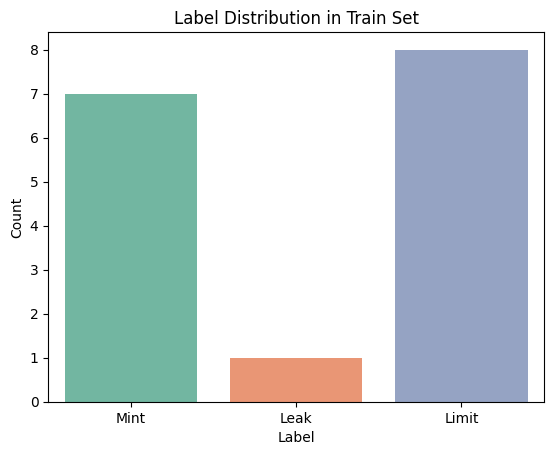

In [161]:
sns.barplot(x=label_counts.index, y=label_counts.values, palette="Set2")
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution in Train Set')
plt.show()

####### Plot Count of Label Combinations

In [162]:
combine_df = pd.DataFrame({})
# Convert one-hot columns to label strings
def get_labels(row):
    return ','.join([
        label for label in label_cols
        if row[label] == 1
    ])

combine_df['label_combo'] = y_dis.apply(get_labels, axis=1)
combine_df['label_combo'] = combine_df['label_combo'].replace('', 'None')  # Replace empty with 'None'
# Count combinations
combo_counts = combine_df['label_combo'].value_counts()
combo_counts

,count
label_combo,
None,13
Limit,5
Mint,4
"Mint,Limit",3
Leak,1


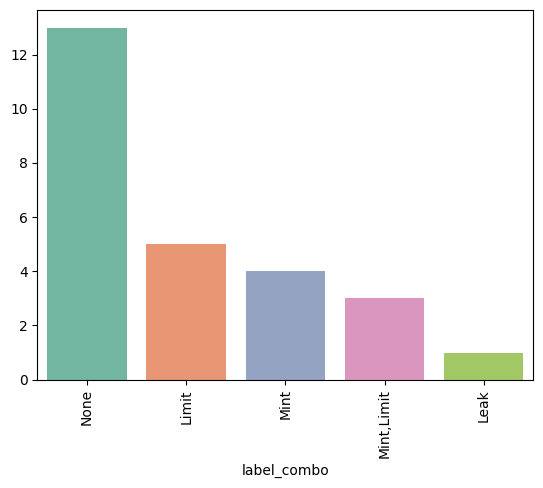

In [163]:
sns.barplot(x=combo_counts.index, y=combo_counts.values, palette="Set2")
plt.xticks(rotation=90)
plt.show()

###### Test

In [164]:
y_dis = pd.DataFrame(y_test_filtered, columns=label_cols)
label_counts = y_dis.sum()
label_counts

,0
Mint,3
Leak,1
Limit,5


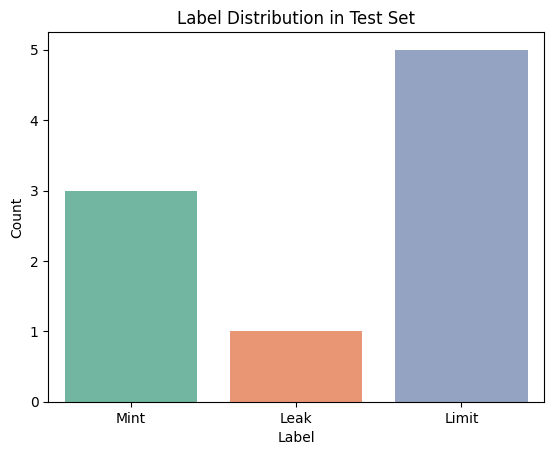

In [165]:
sns.barplot(x=label_counts.index, y=label_counts.values, palette="Set2")
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution in Test Set')
plt.show()

####### Plot Count of Label Combinations

In [166]:
combine_df = pd.DataFrame({})
# Convert one-hot columns to label strings
def get_labels(row):
    return ','.join([
        label for label in label_cols
        if row[label] == 1
    ])

combine_df['label_combo'] = y_dis.apply(get_labels, axis=1)
combine_df['label_combo'] = combine_df['label_combo'].replace('', 'None')  # Replace empty with 'None'
# Count combinations
combo_counts = combine_df['label_combo'].value_counts()
combo_counts

,count
label_combo,
None,6
"Mint,Limit",3
"Leak,Limit",1
Limit,1


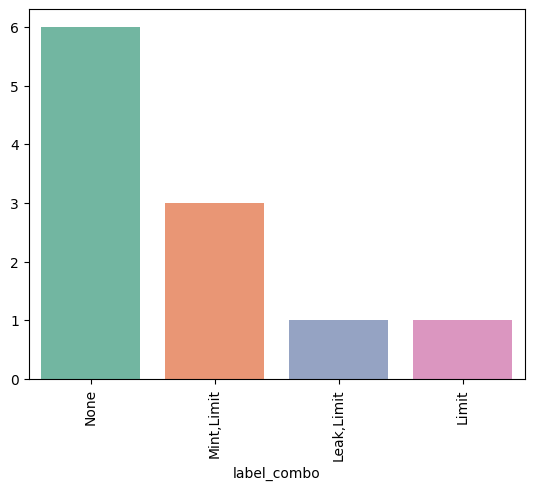

In [167]:
sns.barplot(x=combo_counts.index, y=combo_counts.values, palette="Set2")
plt.xticks(rotation=90)
plt.show()

##### Model & train

In [168]:
model = GCN(in_channels=graph_feature.shape[1], hidden=64, out_channels=len(label_cols))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()  # For multi-label classification

In [169]:
for epoch in range(1, 51):  # max 50 epochs
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch)
        loss = loss_fn(out, batch.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        preds = (torch.sigmoid(out) > 0.5).int().cpu().numpy()
        labels = batch.y.int().cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels)

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    acc = (all_preds == all_labels).mean()

    print(f"Epoch {epoch}, Loss: {total_loss:.4f}, Accuracy: {acc:.4f}")

Epoch 1, Loss: 10.5294, Accuracy: 0.7692
Epoch 2, Loss: 13.4114, Accuracy: 0.6667
Epoch 3, Loss: 6.7777, Accuracy: 0.7308
Epoch 4, Loss: 8.0286, Accuracy: 0.7949
Epoch 5, Loss: 3.4893, Accuracy: 0.7436
Epoch 6, Loss: 17.0295, Accuracy: 0.7564
Epoch 7, Loss: 8.7054, Accuracy: 0.7051
Epoch 8, Loss: 12.7356, Accuracy: 0.7179
Epoch 9, Loss: 14.4702, Accuracy: 0.7179
Epoch 10, Loss: 14.0486, Accuracy: 0.7308
Epoch 11, Loss: 10.8716, Accuracy: 0.7821
Epoch 12, Loss: 10.7068, Accuracy: 0.7949
Epoch 13, Loss: 12.1870, Accuracy: 0.7308
Epoch 14, Loss: 12.0068, Accuracy: 0.6923
Epoch 15, Loss: 11.8048, Accuracy: 0.7308
Epoch 16, Loss: 4.4001, Accuracy: 0.7821
Epoch 17, Loss: 8.6791, Accuracy: 0.7949
Epoch 18, Loss: 2.0244, Accuracy: 0.7821
Epoch 19, Loss: 10.1495, Accuracy: 0.7949
Epoch 20, Loss: 7.0928, Accuracy: 0.7308
Epoch 21, Loss: 6.9193, Accuracy: 0.7564
Epoch 22, Loss: 7.7947, Accuracy: 0.7949
Epoch 23, Loss: 4.1550, Accuracy: 0.8205
Epoch 24, Loss: 4.4058, Accuracy: 0.7564
Epoch 25, Los

In [170]:
model.eval()
y_true, y_probs = [], []
with torch.no_grad():
    for batch in test_loader:
        out = torch.sigmoid(model(batch))
        y_probs.append(out.cpu())
        y_true.append(batch.y.cpu())

y_true = np.vstack(y_true)
y_probs = np.vstack(y_probs)

best_thresholds, _ = tune_thresholds(y_true, y_probs)

Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.12, Best f1 = 0.6667
Label 2: Best threshold = 0.17, Best f1 = 0.8000


##### Result

In [171]:
evaluate_multilabel_classification(y_true, y_probs, label_names=label_cols, threshold=best_thresholds)

({'micro_precision': 0.4444444444444444,
  'micro_recall': 0.8888888888888888,
  'micro_f1': 0.5925925925925926,
  'macro_precision': 0.5242424242424243,
  'macro_recall': 0.9333333333333332,
  'macro_f1': 0.6317460317460317,
  'weighted_precision': 0.5909090909090909,
  'weighted_recall': 0.8888888888888888,
  'weighted_f1': 0.6613756613756614,
  'subset_accuracy': 0.18181818181818182},
               precision    recall  f1-score  support
 Mint           0.272727  1.000000  0.428571      3.0
 Leak           0.500000  1.000000  0.666667      1.0
 Limit          0.800000  0.800000  0.800000      5.0
 micro avg      0.444444  0.888889  0.592593      9.0
 macro avg      0.524242  0.933333  0.631746      9.0
 weighted avg   0.590909  0.888889  0.661376      9.0
 samples avg    0.378788  0.409091  0.375758      9.0)

#### Control Flow

In [172]:
graph_feature = load_feature('cfg_graph_features.csv')
graph_feature.index = graph_feature.index.str.lower()
graphs = pickle.load(open(os.path.join(PATH, 'cfg.pkl'), 'rb'))

In [173]:
train_dataset, test_dataset = [], []
y_train_filtered, y_test_filtered = [], []
for i, (address, graph_data) in enumerate(graphs.items()):
    feature = graph_feature.loc[address]
    data = from_networkx(graph_data)

    data.x = torch.tensor(feature, dtype=torch.float32).repeat(data.num_nodes, 1) # Repeat features for each node
    data.y = torch.tensor(y.loc[address][label_cols].values, dtype=torch.float32).unsqueeze(0) # Add a batch dimension

    if address in train_idx:
        train_dataset.append(data)
        y_train_filtered.append(y.loc[address])
    elif address in test_idx:
        test_dataset.append(data)
        y_test_filtered.append(y.loc[address])

    if i < 10:
        print(data)

Data(edge_index=[2, 118], num_nodes=155, x=[155, 6], y=[1, 3])
Data(edge_index=[2, 96], num_nodes=194, x=[194, 6], y=[1, 3])
Data(edge_index=[2, 178], num_nodes=339, x=[339, 6], y=[1, 3])
Data(edge_index=[2, 78], num_nodes=113, x=[113, 6], y=[1, 3])
Data(edge_index=[2, 211], num_nodes=303, x=[303, 6], y=[1, 3])
Data(edge_index=[2, 158], num_nodes=377, x=[377, 6], y=[1, 3])
Data(edge_index=[2, 365], num_nodes=683, x=[683, 6], y=[1, 3])
Data(edge_index=[2, 137], num_nodes=215, x=[215, 6], y=[1, 3])
Data(edge_index=[2, 96], num_nodes=192, x=[192, 6], y=[1, 3])
Data(edge_index=[2, 4], num_nodes=584, x=[584, 6], y=[1, 3])


In [174]:
len(train_dataset), len(test_dataset)

(47, 20)

In [175]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

##### Label distibution

###### Train

In [176]:
y_dis = pd.DataFrame(y_train_filtered, columns=label_cols)
label_counts = y_dis.sum()
label_counts

,0
Mint,12
Leak,5
Limit,17


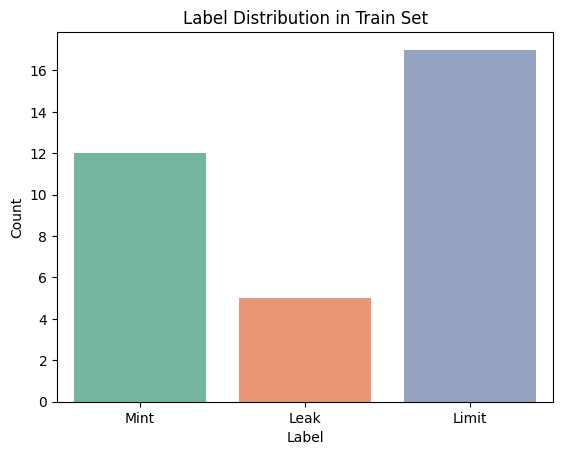

In [177]:
sns.barplot(x=label_counts.index, y=label_counts.values, palette="Set2")
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution in Train Set')
plt.show()

####### Plot Count of Label Combinations

In [178]:
combine_df = pd.DataFrame({})
# Convert one-hot columns to label strings
def get_labels(row):
    return ','.join([
        label for label in label_cols
        if row[label] == 1
    ])

combine_df['label_combo'] = y_dis.apply(get_labels, axis=1)
combine_df['label_combo'] = combine_df['label_combo'].replace('', 'None')  # Replace empty with 'None'
# Count combinations
combo_counts = combine_df['label_combo'].value_counts()
combo_counts

,count
label_combo,
None,20
Limit,11
Mint,6
"Mint,Limit",5
Leak,3
"Leak,Limit",1
"Mint,Leak",1


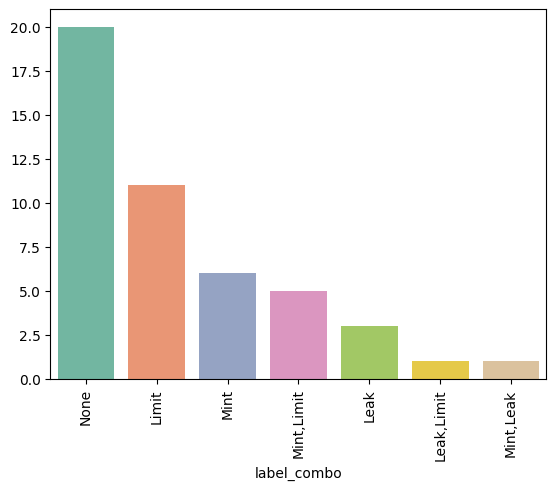

In [179]:
sns.barplot(x=combo_counts.index, y=combo_counts.values, palette="Set2")
plt.xticks(rotation=90)
plt.show()

###### Test

In [180]:
y_dis = pd.DataFrame(y_test_filtered, columns=label_cols)
label_counts = y_dis.sum()
label_counts

,0
Mint,7
Leak,4
Limit,11


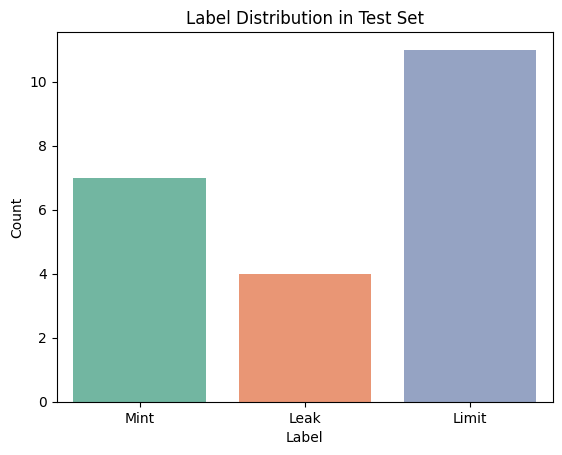

In [181]:
sns.barplot(x=label_counts.index, y=label_counts.values, palette="Set2")
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution in Test Set')
plt.show()

####### Plot Count of Label Combinations

In [182]:
combine_df = pd.DataFrame({})
# Convert one-hot columns to label strings
def get_labels(row):
    return ','.join([
        label for label in label_cols
        if row[label] == 1
    ])

combine_df['label_combo'] = y_dis.apply(get_labels, axis=1)
combine_df['label_combo'] = combine_df['label_combo'].replace('', 'None')  # Replace empty with 'None'
# Count combinations
combo_counts = combine_df['label_combo'].value_counts()
combo_counts

,count
label_combo,
None,7
"Mint,Limit",4
"Leak,Limit",3
Limit,3
Mint,2
"Mint,Leak,Limit",1


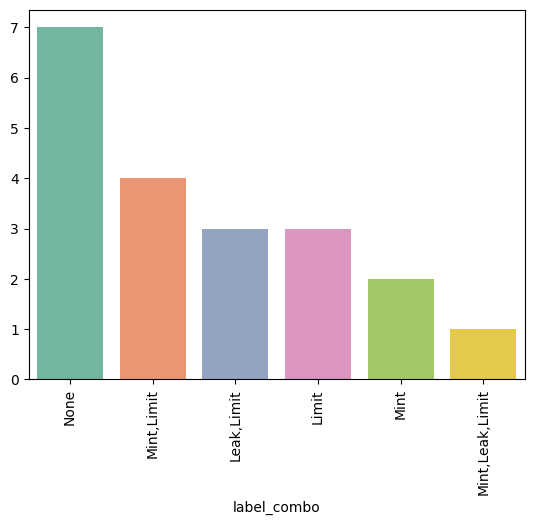

In [183]:
sns.barplot(x=combo_counts.index, y=combo_counts.values, palette="Set2")
plt.xticks(rotation=90)
plt.show()

##### Model & train

In [184]:
model = GCN(in_channels=graph_feature.shape[1], hidden=64, out_channels=len(label_cols))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()  # For multi-label classification

In [185]:
for epoch in range(1, 51):  # max 50 epochs
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch)
        loss = loss_fn(out, batch.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        preds = (torch.sigmoid(out) > 0.5).int().cpu().numpy()
        labels = batch.y.int().cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels)

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    acc = (all_preds == all_labels).mean()

    print(f"Epoch {epoch}, Loss: {total_loss:.4f}, Accuracy: {acc:.4f}")

Epoch 1, Loss: 75.5438, Accuracy: 0.2695
Epoch 2, Loss: 18.2572, Accuracy: 0.5319
Epoch 3, Loss: 16.0788, Accuracy: 0.7589
Epoch 4, Loss: 14.5189, Accuracy: 0.7021
Epoch 5, Loss: 13.5791, Accuracy: 0.7092
Epoch 6, Loss: 10.3685, Accuracy: 0.7092
Epoch 7, Loss: 7.5197, Accuracy: 0.7518
Epoch 8, Loss: 4.7441, Accuracy: 0.6454
Epoch 9, Loss: 4.3813, Accuracy: 0.5887
Epoch 10, Loss: 3.9501, Accuracy: 0.7447
Epoch 11, Loss: 3.6479, Accuracy: 0.7305
Epoch 12, Loss: 3.9558, Accuracy: 0.6809
Epoch 13, Loss: 4.1000, Accuracy: 0.6738
Epoch 14, Loss: 4.2112, Accuracy: 0.6950
Epoch 15, Loss: 3.9412, Accuracy: 0.6809
Epoch 16, Loss: 3.7636, Accuracy: 0.7589
Epoch 17, Loss: 3.4335, Accuracy: 0.7376
Epoch 18, Loss: 3.3139, Accuracy: 0.7234
Epoch 19, Loss: 3.2124, Accuracy: 0.7518
Epoch 20, Loss: 3.5087, Accuracy: 0.7730
Epoch 21, Loss: 3.2493, Accuracy: 0.7872
Epoch 22, Loss: 3.6552, Accuracy: 0.7730
Epoch 23, Loss: 3.5043, Accuracy: 0.7021
Epoch 24, Loss: 3.7496, Accuracy: 0.7305
Epoch 25, Loss: 4.3

In [186]:
model.eval()
y_true, y_probs = [], []
with torch.no_grad():
    for batch in test_loader:
        out = torch.sigmoid(model(batch))
        y_probs.append(out.cpu())
        y_true.append(batch.y.cpu())

y_true = np.vstack(y_true)
y_probs = np.vstack(y_probs)

best_thresholds, _ = tune_thresholds(y_true, y_probs)

Label 0: Best threshold = 0.04, Best f1 = 0.6087
Label 1: Best threshold = 0.00, Best f1 = 0.3333
Label 2: Best threshold = 0.00, Best f1 = 0.7097


In [187]:
model = GCN(in_channels=graph_feature.shape[1], hidden=64, out_channels=len(label_cols))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()  # For multi-label classification

In [188]:
for epoch in range(1, 51):  # max 50 epochs
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch)
        loss = loss_fn(out, batch.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        preds = (torch.sigmoid(out) > 0.5).int().cpu().numpy()
        labels = batch.y.int().cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels)

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    acc = (all_preds == all_labels).mean()

    print(f"Epoch {epoch}, Loss: {total_loss:.4f}, Accuracy: {acc:.4f}")

Epoch 1, Loss: 18.0940, Accuracy: 0.6809
Epoch 2, Loss: 8.4227, Accuracy: 0.6879
Epoch 3, Loss: 8.4707, Accuracy: 0.6879
Epoch 4, Loss: 6.4605, Accuracy: 0.6170
Epoch 5, Loss: 4.0958, Accuracy: 0.6667
Epoch 6, Loss: 4.2030, Accuracy: 0.7801
Epoch 7, Loss: 3.5218, Accuracy: 0.7943
Epoch 8, Loss: 3.2563, Accuracy: 0.6879
Epoch 9, Loss: 3.0630, Accuracy: 0.8014
Epoch 10, Loss: 3.2103, Accuracy: 0.7447
Epoch 11, Loss: 3.1110, Accuracy: 0.7730
Epoch 12, Loss: 3.5806, Accuracy: 0.7518
Epoch 13, Loss: 3.3465, Accuracy: 0.7730
Epoch 14, Loss: 3.0444, Accuracy: 0.7943
Epoch 15, Loss: 3.2707, Accuracy: 0.7518
Epoch 16, Loss: 3.0249, Accuracy: 0.7943
Epoch 17, Loss: 2.9978, Accuracy: 0.8085
Epoch 18, Loss: 3.1259, Accuracy: 0.8156
Epoch 19, Loss: 2.9242, Accuracy: 0.8298
Epoch 20, Loss: 2.9684, Accuracy: 0.8085
Epoch 21, Loss: 2.9324, Accuracy: 0.8298
Epoch 22, Loss: 2.8309, Accuracy: 0.8156
Epoch 23, Loss: 2.8676, Accuracy: 0.8298
Epoch 24, Loss: 3.2733, Accuracy: 0.8156
Epoch 25, Loss: 3.7637, 

In [189]:
model.eval()
y_true, y_probs = [], []
with torch.no_grad():
    for batch in test_loader:
        out = torch.sigmoid(model(batch))
        y_probs.append(out.cpu())
        y_true.append(batch.y.cpu())

y_true = np.vstack(y_true)
y_probs = np.vstack(y_probs)

best_thresholds, _ = tune_thresholds(y_true, y_probs)

Label 0: Best threshold = 0.30, Best f1 = 0.6667
Label 1: Best threshold = 0.00, Best f1 = 0.3333
Label 2: Best threshold = 0.00, Best f1 = 0.7097


##### Result

In [190]:
evaluate_multilabel_classification(y_true, y_probs, label_names=label_cols, threshold=best_thresholds)

({'micro_precision': 0.4074074074074074,
  'micro_recall': 1.0,
  'micro_f1': 0.5789473684210527,
  'macro_precision': 0.4166666666666667,
  'macro_recall': 1.0,
  'macro_f1': 0.5698924731182796,
  'weighted_precision': 0.4704545454545455,
  'weighted_recall': 1.0,
  'weighted_f1': 0.627565982404692,
  'subset_accuracy': 0.05},
               precision  recall  f1-score  support
 Mint           0.500000    1.00  0.666667      7.0
 Leak           0.200000    1.00  0.333333      4.0
 Limit          0.550000    1.00  0.709677     11.0
 micro avg      0.407407    1.00  0.578947     22.0
 macro avg      0.416667    1.00  0.569892     22.0
 weighted avg   0.470455    1.00  0.627566     22.0
 samples avg    0.383333    0.65  0.471667     22.0)